In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing Libraries**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


# **Define Data Directory and Categories**

In [3]:
data_dir = "/content/drive/MyDrive/knee-project"
categories = ["Normal", "Severe", "Mild", "Doubtful", "Moderate"]


# **Preprocessing Function**

In [4]:
#def preprocess_image(image_path):
    #image = cv2.imread(image_path)
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #cropped_image = image[16:240, 16:240]  # Crop to center 224x224 region
    #resized_image = cv2.resize(cropped_image, (224, 224))
    #return resized_image


In [5]:
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    # Get the dimensions of the original image
    height, width, _ = image.shape

    # Define the coordinates to crop the image around its center
    center_x = width // 2
    center_y = height // 2
    crop_width = min(width, height)
    crop_height = min(width, height)

    # Calculate the cropping boundaries
    x1 = center_x - crop_width // 2
    y1 = center_y - crop_height // 2
    x2 = center_x + crop_width // 2
    y2 = center_y + crop_height // 2

    # Crop the central region
    cropped_image = image[y1:y2, x1:x2]

    # Pad the cropped image to match the target size
    pad_x = (target_size[0] - crop_width) // 2
    pad_y = (target_size[1] - crop_height) // 2
    padded_image = cv2.copyMakeBorder(cropped_image, pad_y, pad_y, pad_x, pad_x, cv2.BORDER_CONSTANT)

    # Resize the image to the target size
    resized_image = cv2.resize(padded_image, target_size)

    return resized_image


# **Load Images and Labels**

In [6]:
images = []
labels = []
for category_id, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    for image_name in os.listdir(folder_path):
        if image_name.endswith(".png"):  # Ensure only PNG images are considered
            image_path = os.path.join(folder_path, image_name)
            preprocessed_image = preprocess_image(image_path)
            images.append(preprocessed_image)
            labels.append(category_id)


In [7]:
images[0].shape

(224, 224, 3)

# **Split Data**

In [8]:
images = np.array(images)
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [9]:
X_train.shape

(1320, 224, 224, 3)

In [10]:
X_train.reshape(-1,224,224,1).shape

(3960, 224, 224, 1)

# **Data Generators**

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)


# **Loading Pre-trained Models**

Define Models

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# # Load the data
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# # Preprocess the data
# X_train = X_train.astype('float32') / 255.0
# X_test = X_test.astype('float32') / 255.0
# X_train = X_train.reshape(-1, 28, 28, 1)
# X_test = X_test.reshape(-1, 28, 28, 1)

# # Define the VGG model
# inputs = Input(shape=(28, 28, 1))

# x = Conv2D(64, (3, 3), activation='relu')(inputs)
# x = MaxPooling2D((2, 2))(x)

# x = Conv2D(128, (3, 3), activation='relu')(x)
# x = MaxPooling2D((2, 2))(x)

# x = Conv2D(256, (3, 3), activation='relu')(x)
# x = MaxPooling2D((2, 2))(x)

# x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)
# outputs = Dense(10, activation='softmax')(x)

# model_vgg = Model(inputs=inputs, outputs=outputs)

# # Define the MobileNet model
# inputs = Input(shape=(28, 28, 1))

# x = Conv2D(32, (3, 3), activation='relu')(inputs)
# x = MaxPooling2D((2, 2))(x)

# x = Conv2D(64, (3, 3), activation='relu')(x)
# x = MaxPooling2D((2,2))(x)

# **Custom Classification Head**

In [ ]:
base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the layers of the pre-trained VGG19 model
for layer in base_model_vgg.layers:
    layer.trainable = False
# Add custom classification layers on top of the pre-trained model
x_vgg = base_model_vgg.output
x_vgg = GlobalAveragePooling2D()(x_vgg)
predictions_vgg = Dense(len(categories), activation='softmax')(x_vgg)
# Create the final model by combining the pre-trained base model and custom classification layers
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions_vgg)
#
model_vgg.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#
model_vgg.summary()

# predictions_mobilenet = Dense(len(categories), activation='softmax')(x_mobilenet)
# x_mobilenet = base_model_mobilenet.output
# x_mobilenet = GlobalAveragePooling2D()(x_mobilenet)

# base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# **Compiling Models**

In [ ]:
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions_vgg)
# model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions_mobilenet)

model_vgg.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_mobilenet.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# **Training Models**

In [ ]:
# Install the required modules
# !pip install tensorflow

# Import the required modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy



# Train the models
history_vgg = model_vgg.fit(train_generator, steps_per_epoch=len(X_train) // batch_size, epochs=20,
                            validation_data=test_generator, validation_steps=len(X_test) // batch_size,)
                            # callbacks=[checkpoint_vgg, early_stopping])

# history_mobilenet = model_mobilenet.fit(train_generator, steps_per_epoch=len(X_train) // batch_size, epochs=20,
#                                         validation_data=test_generator, validation_steps=len(X_test) // batch_size,)
                                        # callbacks=[checkpoint_mobilenet, early_stopping])

Epoch 1/20
41/41 [==============================] - 20s 465ms/step - loss: 1.5884 - accuracy: 0.2896 - val_loss: 1.4871 - val_accuracy: 0.3781
Epoch 2/20
41/41 [==============================] - 18s 435ms/step - loss: 1.5313 - accuracy: 0.3183 - val_loss: 1.4714 - val_accuracy: 0.3625
Epoch 3/20
41/41 [==============================] - 20s 474ms/step - loss: 1.5273 - accuracy: 0.3106 - val_loss: 1.4743 - val_accuracy: 0.4031
Epoch 4/20
41/41 [==============================] - 19s 464ms/step - loss: 1.5231 - accuracy: 0.3137 - val_loss: 1.4682 - val_accuracy: 0.4000
Epoch 5/20
41/41 [==============================] - 18s 435ms/step - loss: 1.5164 - accuracy: 0.3043 - val_loss: 1.4717 - val_accuracy: 0.3938
Epoch 6/20
41/41 [==============================] - 18s 433ms/step - loss: 1.5147 - accuracy: 0.3307 - val_loss: 1.4622 - val_accuracy: 0.4187
Epoch 7/20
41/41 [==============================] - 19s 445ms/step - loss: 1.5007 - accuracy: 0.3346 - val_loss: 1.4652 - val_accuracy: 0.3844

# **Model Evaluation**

In [ ]:
vgg_accuracy = model_vgg.evaluate(test_generator)
print(type(vgg_accuracy))

11/11 [==============================] - 2s 158ms/step - loss: 1.4105 - accuracy: 0.4061
<class 'list'>


In [ ]:
# Check model definitions
print("Model VGG summary:")
model_vgg.summary()

# #print("\nModel MobileNet summary:")
# model_mobilenet.summary()

# Check data generator
print("\nTest generator:")
print(test_generator)

# Check data format
print("\nTest generator data format:")
print(test_generator[0][0].shape)



# Evaluate models and handle potential tuple result
vgg_accuracy = model_vgg.evaluate(test_generator)
if isinstance(vgg_accuracy, tuple):
    vgg_accuracy = vgg_accuracy[1]

#mobilenet_accuracy = model_mobilenet.evaluate(test_generator)
# if isinstance(mobilenet_accuracy, tuple):
#     mobilenet_accuracy = mobilenet_accuracy[1]

# Print accuracy values
print("\nVGG Accuracy:", vgg_accuracy)
# print("MobileNet Accuracy:", mobilenet_accuracy)

Model VGG summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56

In [ ]:
# Define the directory containing test images
test_dir = "/content/drive/MyDrive/knee-project/test"

# Initialize an empty list to store image data
test_images = []

# Iterate over the images in the directory
for image_name in os.listdir(test_dir):
    if image_name.endswith(".png"):  # Check if the file is a PNG image
        image_path = os.path.join(test_dir, image_name)
        # Read the image and resize it to 224x224 pixels
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (224, 224))
        # Append the image data to the list
        test_images.append(image)

# Convert the list of images to a numpy array
x_test = np.array(test_images)


# **Heat map**

In [ ]:
print(image_path)
img = preprocess_image(image_path)
img.shape

/content/drive/MyDrive/knee-project/Moderate/ModerateG3 (218).png


(224, 224, 3)

1/1 [==============================] - 1s 1s/step


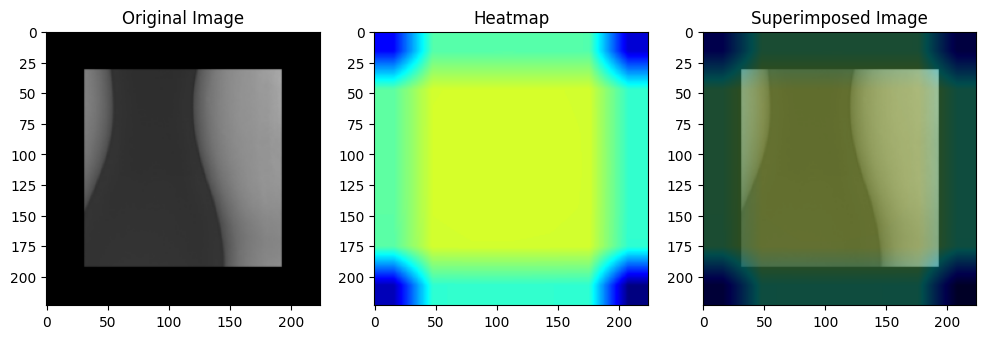

In [ ]:
# Function to generate and visualize heatmaps for VGG19 and MobileNet models
def generate_heatmap(model, image_path):
    # Load and preprocess the image
    img = preprocess_image(image_path)
    img_input = img.reshape(1, 224, 224, 3) / 255.0  # Normalize to [0, 1]

    # Get the activation maps from the last convolutional layer
    last_conv_layer = model.get_layer(index=-3)
    heatmap_model = Model(model.inputs, last_conv_layer.output)
    heatmap_output = heatmap_model.predict(img_input)

    # Compute the class activation heatmap
    heatmap = np.mean(heatmap_output, axis=-1)[0]
    heatmap = np.maximum(heatmap, 0)  # Remove negative values
    heatmap /= np.max(heatmap)  # Normalize to [0, 1]

    # Resize the heatmap to the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Superimpose the heatmap on the original image
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)

    # Display the original image, heatmap, and superimposed image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img.squeeze(), cmap='gray')
    plt.title('Superimposed Image')

    plt.show()


generate_heatmap(model_vgg, image_path)

# Example usage for MobileNet
# generate_heatmap(model_mobilenet, sample_image_path)
